In [1]:
import numpy as np
import matplotlib.pyplot as plt

filename_list = ['2021-03-04_rIAPP_2n5_sliceB_0V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_10V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_20V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_30V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_40V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_50V_02_dt_extracted.txt']

datastore = {}
for filename in filename_list:
    with open (filename, 'r') as f:
        filenameparts = filename.split('_')
        voltage = filenameparts[4].replace('V', '')
        voltage = int(voltage)
        arrtime = []
        intensity = []
        for dataline in f:
            dataline = dataline.replace('\n', '')
            arrtime_intensity = dataline.split('\t')
            arrtime.append(float(arrtime_intensity[0]))
            intensity.append(float(arrtime_intensity[1]))         
            pairs = list(zip(arrtime, intensity))
        datastore[voltage] = pairs
#print(len(arrtime))
#print(len(intensity))

intensity0 = [0]*200
pairs0 = list(zip(arrtime, intensity0))

datastore[-10] = pairs0

for k, v in datastore.items():
    print(k)

print(len(datastore))

0
10
20
30
40
50
-10
7


In [2]:
arrts_for2d = []
intens_for2d = []
volts_for2d = []

for k, pair in sorted(datastore.items()):
    for i in pair:
        arrts_for2d.append(i[0])
        intens_for2d.append(i[1])
        volts_for2d.append(k)
                

[-10   0  10  20  30  40  50]
-10
[-10.          -9.69849246  -9.39698492  -9.09547739  -8.79396985
  -8.49246231  -8.19095477  -7.88944724  -7.5879397   -7.28643216
  -6.98492462  -6.68341709  -6.38190955  -6.08040201  -5.77889447
  -5.47738693  -5.1758794   -4.87437186  -4.57286432  -4.27135678
  -3.96984925  -3.66834171  -3.36683417  -3.06532663  -2.7638191
  -2.46231156  -2.16080402  -1.85929648  -1.55778894  -1.25628141
  -0.95477387  -0.65326633  -0.35175879  -0.05025126   0.25125628
   0.55276382   0.85427136   1.15577889   1.45728643   1.75879397
   2.06030151   2.36180905   2.66331658   2.96482412   3.26633166
   3.5678392    3.86934673   4.17085427   4.47236181   4.77386935
   5.07537688   5.37688442   5.67839196   5.9798995    6.28140704
   6.58291457   6.88442211   7.18592965   7.48743719   7.78894472
   8.09045226   8.3919598    8.69346734   8.99497487   9.29648241
   9.59798995   9.89949749  10.20100503  10.50251256  10.8040201
  11.10552764  11.40703518  11.70854271  12.

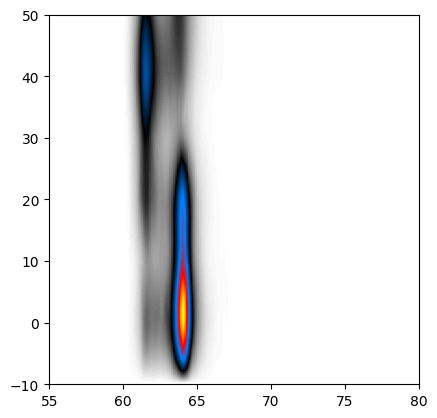

In [3]:
from scipy.interpolate import interp2d, RectBivariateSpline, CloughTocher2DInterpolator
from matplotlib.colors import LinearSegmentedColormap

#X2d = np.array(arrts_for2d)
#Y2d = np.array(volts_for2d)
#Z2d = np.array(intens_for2d)

X2d = np.array(sorted(set(arrts_for2d))) #flat list
Y2d = np.array(sorted(set(volts_for2d))) #flat list 0 to 70 once
Z2d = np.array(intens_for2d)
Z2d = Z2d.reshape(len(Y2d), len(X2d)).T

print(Y2d)

#interp_func = interp2d(X2d, Y2d, Z2d, kind='cubic', fill_value=0.0)
#interp_func = RectBivariateSpline(X2d, Y2d, Z2d, kx=3, ky=3, s=0)

x_grid, y_grid = np.meshgrid(X2d, Y2d) # n_grid , n_grid of coordinates
x_grid_flat = x_grid.ravel()  # Flatten to list
y_grid_flat = y_grid.ravel() 
stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

ztest = Z2d.T.ravel()
nz = ztest.nonzero()

interp_func = CloughTocher2DInterpolator(stacked_points, ztest) # , kernel='gaussian', epsilon=0.1)

X_max = 80
X_min = X2d.min()
Y_min = Y2d.min()
Y_max = 50

print(Y_min)

#n_smooth = 100
n_smoothy = 200
n_smoothx = 200

X2d_plot = np.linspace(X_min, X_max, n_smoothx)
Y2d_plot = np.linspace(Y_min, Y_max, n_smoothy) 
print(Y2d_plot)

x_grid, y_grid = np.meshgrid(X2d_plot, Y2d_plot) # n_grid , n_grid of coordinates
x_grid_flat = x_grid.ravel()  # Flatten to list
y_grid_flat = y_grid.ravel() 
stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

Intens2d_plot = interp_func(stacked_points).reshape(n_smoothx, n_smoothy)
#Intens2d_plot = interp_func(X2d_plot, Y2d_plot).T
Intens2d_plot = np.clip(Intens2d_plot, a_min = 0, a_max = None)


#Intens2d_plot = interp_func(X2d_plot, Y2d_plot)
print(Intens2d_plot.shape)

#density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF','#000080','#0080FF'], N=256)
density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF', '#000000','#0080FF','#FF0000','#FFFF00'], N=256)

fig, ax = plt.subplots()
x_range = (X_min, X_max) #min and max, effectively, cos it's sorted
y_range = (Y_min, Y_max)

aspect = (x_range[1] - x_range[0])/(y_range[1] - y_range[0])

#Intens2d_plot = np.clip(Intens2d_plot, 0.0, None)

ax.imshow(Intens2d_plot, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=aspect, vmin=0.0)
plt.show()

In [4]:
Volts_new = Y2d_plot # np.linspace(0, 70, 200)

n,m = Intens2d_plot.shape

x_smootharrT_coords = []
y_smoothV_coords = []
smooth_intensities = []


for i in range(n):
    for j in range(m):
        intensity_value = int(Intens2d_plot[j,i])
        x_smootharrT_coords.append(X2d_plot[i])        
        y_smoothV_coords.append(Volts_new[j])
        smooth_intensities.append(intensity_value)
print(len(x_smootharrT_coords)) #40,000
print(len(y_smoothV_coords)) #40,000 i.e. 200*200
print(len(smooth_intensities)) #40,000 i.e. 200*200

smoothxycoords = list(zip(x_smootharrT_coords, y_smoothV_coords))
smoothxycoords = np.array(smoothxycoords)
smooth_intensities = np.array(smooth_intensities)

print(smoothxycoords.min(axis=0), smoothxycoords.max(axis=0))
print(smoothxycoords.shape, smooth_intensities.shape)

40000
40000
40000
[ 54.982 -10.   ] [80. 50.]
(40000, 2) (40000,)


(13.877699333993462, -4.534310788015862, 31.755351421125933, 0.17090311857278184, 43.35069074597939, 20.035097981667082, 2.592463261382535)
64.0137723540625 13.877699333993462 72 80 0.011575069208577414
63.27846250679595 -4.534310788015862 66 19 0.004341168303172072
61.4948365487143 31.755351421125933 52 139 0.0063988657779705145
64.04100805787806 0.17090311857278184 73 34 0.01914755556712825
62.841076776474075 43.35069074597939 63 177 0.005023610613233366
63.32664400122896 20.035097981667082 67 100 0.00429352159457627
63.29475581568911 2.592463261382535 67 42 0.007011055391323981


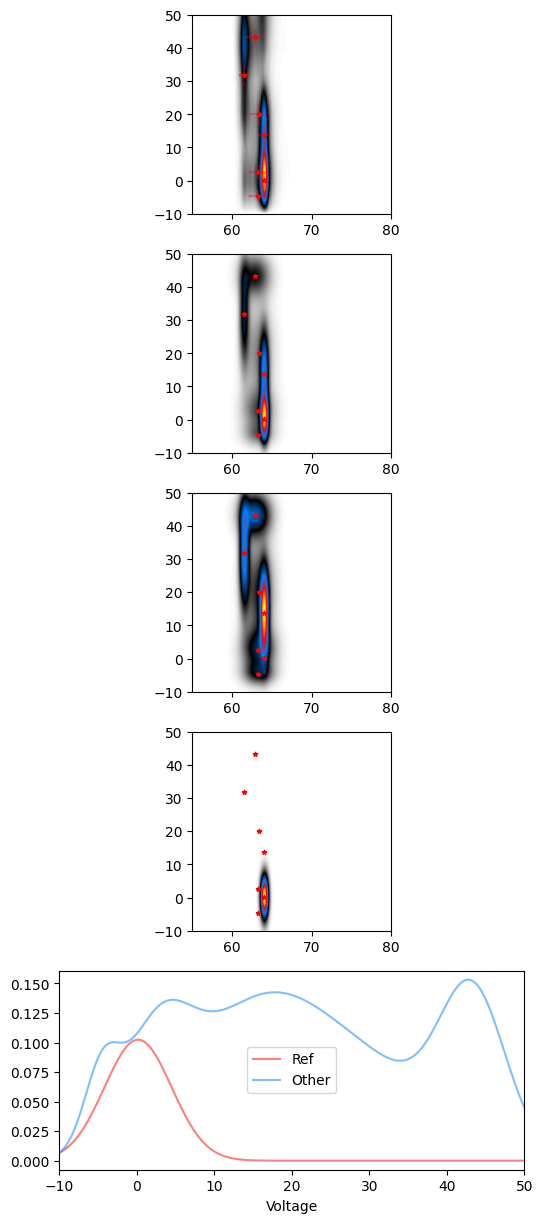

In [5]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class MinStdNormalDistributionX(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 0 #0.4 #0.1 #0.8 #1 #2#0.6
        NormalDistribution.__init__(self, *args, **kw)
class MinStdNormalDistributionY(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 0 #7 #8 #1 #5#11 ##stick w 10
        NormalDistribution.__init__(self, *args, **kw)

test_n_components = [7]

fig1, axarr = plt.subplots(5,len(test_n_components), squeeze=False)
fig1.set_size_inches(6,15)

gmmlist = [] #objects for 3,4,5 components
for i, n_comp in enumerate(test_n_components):
 
    gmm = GeneralMixtureModel.from_samples([MinStdNormalDistributionX, MinStdNormalDistributionY],
                                         n_comp, smoothxycoords, smooth_intensities, n_init=10, max_kmeans_iterations=50, 
                                          stop_threshold=0.1, lr_decay=0.5, verbose=False)
    gmmlist.append(gmm)
    df = (5 * n_comp) - 1
    lp = (gmm.log_probability(smoothxycoords) * smooth_intensities).sum() #sum, as in log space, normally porbs would multiply. 
    bic = float(df * np.log(len(smoothxycoords)) - 2.0 * lp) # For evaluating best n_comp
    
    # For independent x,y normals
    comp_params = [comp.parameters[0] for comp in gmm.distributions] # Selects IndependentComponentsDistribution for each Gaussian
    x_params = [cp[0].parameters for cp in comp_params] # NormalDistribution for X : Mean, Var pairs
    y_params = [cp[1].parameters for cp in comp_params] # NormalDistribution for Y : Mean, Var pairs
  
    x_vals_mean, x_vals_var = zip(*x_params) 
    y_vals_mean, y_vals_var = zip(*y_params) 
    
  # Sqrt for Var to Std
    x_vals_std = np.sqrt(x_vals_var)
    y_vals_std = np.sqrt(y_vals_var)

    print(y_vals_mean)
    
    x_points = X2d_plot # np.linspace(X_min, X_max, n_grid) 
    y_points = Y2d_plot # np.linspace(Y_min, Y_max, n_grid)
    
    x_grid, y_grid = np.meshgrid(x_points, y_points) # n_grid , n_grid of smoothxycoords
    x_grid_flat = x_grid.ravel()  # Flatten to list
    y_grid_flat = y_grid.ravel() 
    stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

    density_all = gmmlist[i].log_probability(stacked_points) # comes as log probabilties
    density_all = np.exp(density_all) # Real probs
    density_all = density_all.reshape([len(x_points), len(y_points)]) # Restore points grid (of heights)
    
    density_separate = gmmlist[i].predict_log_proba(stacked_points) # comes as log probabilties
    #ref_idx = np.argmin(y_vals_mean) ###OLD:: ref idx actually needs be highest intensity val of three closest to 0V (e.g. ratB)###
    density_separate = np.exp(density_separate) # Real probs
        
    inten_at_means = []
    for j, yval in enumerate(y_vals_mean):
        xval = x_vals_mean[j]
        # get axis indices relative to sampled, interpolated grid
        y = np.searchsorted(y_points, yval) #must be pre sorted for this but scans for number(eg yval) and gives back grid points
        x = np.searchsorted(x_points, xval)
        dentest2 = density_all[y, x] #getting the intensity val at the calculated grid points
        print(xval, yval, x, y, dentest2)
        inten_at_means.append(dentest2)

    inten_max_list_pos = np.argmax(inten_at_means)
    yvals_mean_min_list_pos = np.argmin(y_vals_mean)

    if inten_max_list_pos == yvals_mean_min_list_pos:
        ref_idx = inten_max_list_pos
    else:
        yval_inten_max = y_vals_mean[inten_max_list_pos]
        if (yval_inten_max - min(y_vals_mean)) < 15: #hardcoded intentionally.  
            ref_idx = inten_max_list_pos
        else:
            ref_idx = inten_max_list_pos
            print('warning - examine results manually')
    
    other_idx = np.array([idx for idx in range(n_comp) if idx != ref_idx])
    
    density_ref = density_separate[:,ref_idx]
    density_other = density_separate[:,other_idx].sum(axis=1)
    
    density_ref = density_ref.reshape([len(x_points), len(y_points)]) # Restore points grid (of heights)
    density_ref *= density_all
    
    density_other = density_other.reshape([len(x_points), len(y_points)]) # Restore points grid (of heights)
    density_other *= density_all
    
    volt_proj_ref = density_ref.sum(axis=1)
    volt_proj_other = density_other.sum(axis=1)

    ax1 = axarr[0, i] #
    ax1.set_xlim(X_min, X_max)
    ax1.set_ylim(Y_min, Y_max)
    aspect = (X_max - X_min)/(Y_max - Y_min)
    ax1.imshow(Intens2d_plot, cmap=density_colormap, origin='lower', extent=(X_min, X_max, Y_min, Y_max), aspect=aspect) 
    ax1.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')
    ax1.errorbar(x_vals_mean, y_vals_mean, y_vals_std, x_vals_std, fmt='none',
               color='red',alpha=0.3,  label='StdDevs', capsize=0.5)
    
    ax2 = axarr[1, i]
    ax2.set_xlim(X_min, X_max)
    ax2.set_ylim(Y_min, Y_max)
    aspect = (X_max - X_min)/(Y_max - Y_min)
    ax2.imshow(density_all, cmap=density_colormap, origin='lower', extent=(X_min, X_max, Y_min, Y_max), aspect=aspect) 
    ax2.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')
    
    ax3 = axarr[2, i]
    ax3.set_xlim(X_min, X_max)
    ax3.set_ylim(Y_min, Y_max)
    aspect = (X_max - X_min)/(Y_max - Y_min)
    ax3.imshow(density_other, cmap=density_colormap, origin='lower', extent=(X_min, X_max, Y_min, Y_max), aspect=aspect) 
    ax3.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')
    
    ax4 = axarr[3, i]
    ax4.set_xlim(X_min, X_max)
    ax4.set_ylim(Y_min, Y_max)
    aspect = (X_max - X_min)/(Y_max - Y_min)
    ax4.imshow(density_ref, cmap=density_colormap, origin='lower', extent=(X_min, X_max, Y_min, Y_max), aspect=aspect) 
    ax4.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')
    
    ax5 = axarr[4,i]
    ax5.set_xlim(Y_min, Y_max)
    ax5.plot(y_points, volt_proj_ref, alpha=0.5, color='#FF0000', label='Ref')
    ax5.plot(y_points, volt_proj_other, alpha=0.5, color='#0080FF', label='Other')
    ax5.set_xlabel('Voltage')
    ax5.legend()
    
plt.show()

0.0007452865316439268
0.0007942845559846772


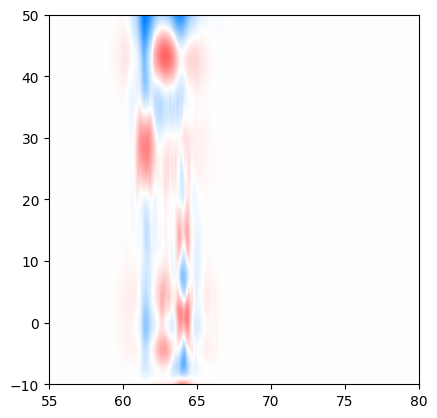

0.0001271281491323361


In [8]:
#print(Intens2d_plot.shape)
#print(density.shape)
#print(density_2d.shape)

norm_orig = Intens2d_plot/Intens2d_plot.sum()
norm_pred = density_all/density_all.sum()#density_2d/density_2d.sum()
print(norm_orig.max())
print(norm_pred.max())

resid = np.subtract(norm_orig, norm_pred)
residual_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FF0000', '#FFFFFF','#0080FF'], N=256)

fig, ax = plt.subplots()

vmax = max(resid.max(), -resid.min())
#vmax = 0.00207
ax.imshow(resid, cmap=residual_colormap, origin='lower', vmin=-vmax, vmax=vmax, 
          extent=(X_min, X_max, Y_min, Y_max), aspect=aspect)

plt.show()

print(vmax)

In [ ]:
resid_sqs = resid * resid
mean_sqs = np.mean(resid_sqs)
rmsd = np.sqrt(mean_sqs)

print(rmsd)

In [ ]:
numbers1 = np.arange(0, 80, 10).tolist()
numbers2 = np.arange(0, 100, 14).tolist()
print(numbers1)
print(numbers2)

fig, ax = plt.subplots()

for i in range(0, 100, 10):
    ax.plot(Intens2d_plot[i,10:(n_smoothx//2)])
    #ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots()
#the vertical range of numbers goes on the xaxis, the ith column of those numbers on the y
#X2d_plot = np.linspace(X_min, X_max, n_smooth) where n_smooth = 100
for i in range(20, len(X2d_plot)//2, 3):
    ax.plot(Y2d_plot, Intens2d_plot[:,i], label=f't={X2d_plot[i]:.2f}', alpha=0.8) # X_plot = np.linspace(0, 70, 100)[:, np.newaxis]

ax.set_title('Time slices')
ax.set_xlabel('Voltage')
ax.set_ylabel('Intensity')
ax.legend(fontsize=7, ncol=2)
plt.show()

In [ ]:
den = density_2d.tolist()
print(den[5])